## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sys
import pickle
import matplotlib.pyplot as plt
import nltk

## Read Dataset

In [2]:
#1) Read the data
data = pd.read_pickle('data/email_campaigns.pkl')
print(len(data))

52


In [3]:
subject, body, opened, clicked_meeting_link, responded = [], [], [], [], []

for i in range(len(data)):    
    for key, val in data[i].items():
        for j in range(len(val)):
            if type(val[j])==type({}):
                subject.append(val[j]["subject"])
                body.append(val[j]["body"])
                opened.append(val[j]["opened"])
                responded.append(val[j]["responded"])
                try:
                    clicked_meeting_link.append(val[j]["meeting link clicked"])
                except:
                    clicked_meeting_link.append(val[j]["meeting_link_clicked"])
            else:
                #print(data[i].keys())
                continue

In [4]:
print(len(subject),len(body),len(opened),len(responded),len(clicked_meeting_link))

154 154 154 154 154


In [5]:
df = pd.DataFrame({"subject":subject,"body":body,"opened":opened,"clicked_meeting_link":clicked_meeting_link,"responded":responded})

In [6]:
df.head()

,subject,body,opened,clicked_meeting_link,responded
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,False
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,False
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,False
3,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,True,False
4,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",False,False,False


In [7]:
df.shape

(154, 5)

## Preprocessing

In [8]:
columns = list(df.columns)
#1) remove special characters, lower case
for col in columns:
    df[col] = df[col].astype(str).str.replace('\W',' ')
    df[col] = df[col].astype(str).str.lower()

/tmp/ipykernel_8463/3761462469.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].astype(str).str.replace('\W',' ')


In [9]:
df.head()

,subject,body,opened,clicked_meeting_link,responded
0,propel your marketing roi with advanced anal...,hey recipient s name ready to see your mar...,false,false,false
1,data is your superpower unlock insights with us,hi recipient s name i m reaching out again...,true,false,false
2,turn marketing data into decisions let s exp...,greetings recipient s name we haven t conn...,false,false,false
3,marketing success is a click away let s chat...,hello recipient s name it s clear that you...,true,true,false
4,boost your brand s visibility with proven ma...,hi recipient s name in the digital age da...,false,false,false


In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

for col in columns:
    df[col].apply(lambda x: [item for item in x if item not in stop])

[nltk_data] Downloading package stopwords to /home/akash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Perform Label Encoding for the target 
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
df["opened"] = l.fit_transform(df["opened"]) 
df["clicked_meeting_link"] = l.fit_transform(df["clicked_meeting_link"])
df["responded"] = l.fit_transform(df["responded"])

In [12]:
print(df.shape)
df.head()

(154, 5)


,subject,body,opened,clicked_meeting_link,responded
0,propel your marketing roi with advanced anal...,hey recipient s name ready to see your mar...,2,2,1
1,data is your superpower unlock insights with us,hi recipient s name i m reaching out again...,3,2,1
2,turn marketing data into decisions let s exp...,greetings recipient s name we haven t conn...,2,2,1
3,marketing success is a click away let s chat...,hello recipient s name it s clear that you...,3,3,1
4,boost your brand s visibility with proven ma...,hi recipient s name in the digital age da...,2,2,1


## EDA of the dataset

In [13]:
#1) Word count
avg_words_subject = sum(df["subject"].str.split().str.len())/len(df["subject"])
avg_words_body = sum(df["body"].str.split().str.len())/len(df["body"])
print("The avg words after preprocessing in subject is : {} and in body is : {}".format(avg_words_subject, avg_words_body))

The avg words after preprocessing in subject is : 7.35064935064935 and in body is : 60.38961038961039


<AxesSubplot: >

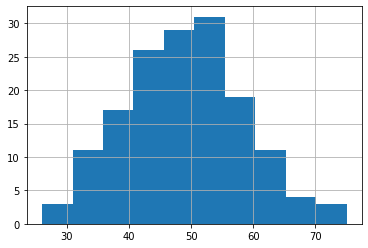

In [14]:
#2) Histogram based on the length of words
df["subject"].str.len().hist()

<AxesSubplot: >

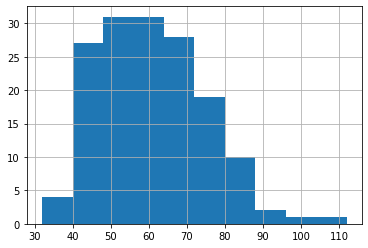

In [15]:
#3) Plot the number of words per body
df["body"].str.split().map(lambda x:len(x)).hist()

<AxesSubplot: >

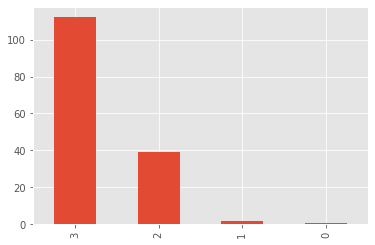

In [16]:
# Show the label counts for opened and not opened 
plt.style.use("ggplot")
fig, ax = plt.subplots()
df['opened'].value_counts().plot(ax=ax, kind='bar')

## Transform the data 

In [17]:
# Build the word_to_idx
subject_words = ' '.join([i for i in df['subject']]).split() 
body_words = ' '.join([i for i in df['body']]).split() 
total_words = subject_words+body_words
print("The total number of words are :",len(total_words))

The total number of words are : 10432


In [18]:
corpus = list(set(total_words))
word_to_idx, idx_to_word = {},{}
word_to_idx["unknown"]=0
idx_to_word[0]="unkwown"

for idx, word in enumerate(corpus):
    word_to_idx[word]=idx
    idx_to_word[idx]=word
    
word_to_idx["unknown"] = len(word_to_idx)
idx_to_word[len(word_to_idx)] = "unknown"

In [19]:
# Use subject and Body as Input

new_subject, new_body, target = [], [], []
max_length = 80

for index, row in df.iterrows():
    row_input = [word_to_idx[word] for word in row["subject"].split()] + [word_to_idx[word] for word in row["body"].split()]
    if len(row_input)>max_length:
        new_subject.append(row_input[:max_length])
    else:
        new_subject.append(row_input+[0]*(max_length-len(row_input)))
    target.append(row["opened"])

In [20]:
print(new_subject[:3])

[[568, 205, 1061, 781, 493, 1109, 191, 749, 730, 429, 60, 817, 1160, 103, 205, 1061, 874, 388, 493, 956, 977, 1165, 1061, 191, 152, 205, 243, 105, 1082, 525, 710, 1141, 328, 1160, 0, 820, 119, 22, 1043, 781, 994, 1091, 53, 906, 432, 205, 328, 1160, 449, 1133, 692, 645, 429, 622, 99, 683, 329, 270, 205, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [328, 618, 205, 1152, 1022, 949, 493, 911, 1011, 730, 429, 60, 1086, 1127, 576, 1032, 1099, 12, 1086, 1057, 956, 732, 288, 698, 1112, 1038, 247, 525, 704, 493, 205, 680, 1106, 720, 956, 1061, 191, 105, 672, 205, 328, 562, 1069, 876, 304, 105, 1185, 205, 1061, 429, 357, 105, 11, 1108, 906, 1082, 323, 1152, 1131, 960, 170, 415, 1041, 282, 683, 329, 508, 370, 1160, 554, 836, 205, 60, 0, 0, 0, 0, 0, 0, 0], [308, 1061, 328, 562, 117, 645, 429, 209, 133, 544, 730, 429, 60, 11, 1128, 825, 46, 736, 22, 1086, 1127, 762, 205, 243, 618, 1046, 1032, 415, 1176, 949, 956, 998, 1061, 191, 105, 351, 919, 525, 346, 1141, 205, 328, 275, 598,

In [21]:
# Concatenate subject and body
input_data = np.array(new_subject)#.reshape(-1,1)
output_data = np.array(target)#.reshape(-1,1)

In [22]:
print(input_data.shape)
print(output_data.shape)

(154, 80)
(154,)


## Model Building

### ML Model

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size=0.3, random_state=2003)

In [24]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0).fit(X_train, Y_train)

/home/akash/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [25]:
y_pred = clf.predict(X_test)

In [26]:
clf.score(X_test,Y_test)

0.5319148936170213

### DL Model

In [27]:
from DL_model import implement_pytorch

In [28]:
print(X_train.shape,Y_train.shape)
batch_size = 8
implement_pytorch(X_train.astype(np.float32),Y_train.astype(np.float32),batch_size)

(107, 80) (107,)
tensor(3.4742, grad_fn=<NllLossBackward0>)


/home/akash/Desktop/Random/Assignment/DL_model.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y[i:i+batch_size]).long()


tensor(0.9675, grad_fn=<NllLossBackward0>)
tensor(0.6809, grad_fn=<NllLossBackward0>)
tensor(0.5712, grad_fn=<NllLossBackward0>)
tensor(0.5246, grad_fn=<NllLossBackward0>)
Accuracy is : tensor(0.3750)


### GloVe Embeddings

In [29]:
from DL_model import implement_with_GloVe

In [30]:
batch_size = 8
EMBEDDING_DIM = 300
HIDDEN_DIM = 375
OUTPUT_DIM = 4

implement_with_GloVe(df, len(word_to_idx), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, batch_size)

AttributeError: 'str' object has no attribute 'values'

## Accuracy or Prediction